In [17]:
# Install packages (other versions may work, but these are the versions I had when I
# tested this script). If running on google colab, it may be necessary to install
# these packages each time a new runtime is connected
!pip install pytorch_lightning==1.8.0
!pip install numpy==1.21.6
!pip install pandas==1.3.5
!pip install torch==1.12.1
!pip install torchtext==0.13.1
!pip install seaborn==0.11.2
!pip install matplotlib==3.2.2
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Import relevant packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl
from collections import OrderedDict
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
from pytorch_lightning.loggers import CSVLogger
from random import choice
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn import metrics

In [19]:
# setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
AAs = 'ACDEFGHIKLMNPQRSTVWY'
WT = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
WT_list = list(WT)

# aa2ind is an ordered dict with keys corresponding to one letter amino acid
# codes and values corresponding to an index. Later, these indices will be
# used for encoding amino acids into vectors
aa2ind = vocab.vocab(OrderedDict([(a, 1) for a in AAs]))
aa2ind.set_default_index(20) # set unknown charcterers to gap


In [20]:
# Set up embedding with aaindex. aaindex is what we will use to convert
# the indicies from aa2ind to a vector of floats that describes each amino acid
# and will serve as inputs to the neural network.

# get aa index embedding
aaindex = np.array([[float(f) for f in l.split(',')[1:]] for l in open('pca-19_raw.csv').read().strip().split('\n')[1:]])
aaindex = (aaindex - aaindex.mean(0))/aaindex.std(0) # standardize
aaindex = np.vstack([aaindex,np.zeros((1,19))]) # add final row to include gap -
aaindex = torch.from_numpy(aaindex).float() 
ncomp = 6 # number of principal components
aaindex = aaindex[:,:ncomp]

### aaindex utilizes pca-19, which is a file with vectors representing each
# amino acid. These vectors were determined by dimensionality reduction (PCA)
# of the physiochemical properties of all amino acids. Emperically, we have found
# that the first six components of this analysis capture ~99.9% of amino acid 
# properties, which is why ncomp is set to 6, but this is a hyperparameter
# that can be tuned to modify model performance

In [21]:
# The funcitons in this cell are for processing the labeled data into a format
# that is more useful for learning. 

# Mutate the WT sequence and output an array of sequences with coresponding scores
def mutate(np_mutations):
    list_updated = []
    count = 0
    for i in range(len(np_mutations)):
        try: 
            muts = np_mutations[i].split(',')
        except:
            muts = np_mutations[i]
            
        # Go through each mutation (there are one or two)
        mut_list = list(WT)
        for mut in muts:
            final_index = int(mut[1:-1]) - 1
            final_AA = mut[-1]/n
            mut_list[final_index] = final_AA
        # Append mutated sequence and score
        list_updated.append(mut_list)
        
    return list_updated

# Fix indexing in variant/mutation entries
# this is only necessary if there are issues with 0 v 1 based indexing
def convert_indexing(variants, offset):
    """ convert between 0-indexed and 1-indexed """
    converted = [",".join(["{}{}{}".format(mut[0], int(mut[1:-1]) + offset, mut[-1])
                           for mut in v.split(",")])
                 for v in variants]
    return converted


In [22]:
# torch.set_num_threads(4) sets the number of threads in use to 4.
# this line if very important if running on the server because pytorch is 
# greedy and will steal all the resources. It is not necessary if running on 
# colab or a personal computer, but it won't break anything if its included
torch.set_num_threads(4) 

# The following loads in the experimentally collected data (thermostability of
# gb1 mutants for this example) and calls above-defined funcitons for processing
df = pd.read_csv("gb1.tsv", sep='\t')
df.variant = convert_indexing(df.variant,1)    
AA_seq_lists = mutate(list(df['variant'].copy()))
AA_seq_lists2 = [str("".join(AA_seq_lists[j])) for j in range(len(AA_seq_lists))]

# Add column of full amino acid sequences. The input to the neural network will
# be full sequences converted into numerical vectors. 
df['AA_sequences'] = AA_seq_lists2

# This shuffles the dataset (pytorch should do this later but its here because
# I'm paranoid). You can change frac to a smaller number like 0.1 to train
# on only a portion of the dataset and speed up training
df = df.sample(frac = 0.1)

In [23]:
# These three classes are the core of the neural network architecture for pytorch
# pytorch is very modular and adaptable, so these classes can be applied to 
# other datasets with minimal modifications.

# SeqFcnDataset is a helper class for loading and formating the data
class SeqFcnDataset(torch.utils.data.Dataset):
    """A custom PyTorch dataset for protein sequence-function data"""
    
    def __init__(self, data_frame):
        self.data_df = data_frame

    def __getitem__(self, idx):
        # index the data frame 
        df_row = self.data_df.iloc[idx]
        # Note that the line below only converts the sequences to indices, the
        # conversion using physiochemical properties (aaindex) occurs later
        # because this script allows the conversion defenitions from index to 
        # vector to change/be learned.
        sequence = torch.tensor(aa2ind(list(df_row.AA_sequences))) # input
        score = torch.tensor(df_row.score) # output
        return sequence, score.float()

    def __len__(self):
        return len(self.data_df)


# ProtDataModule splits the data into three different datasets:
# training: this is the data that the model will learn from 
# validation/development: the model will not learn from this data, but you do
# make predictions on this dataset throughout training. The performance on this
# data can be informative as to whether the neural network is overfitting and 
# can be useful for optimizing hyperparameters
# test: the test dataset is not used until the end. This provided us an unbiased
# assesment of model performance.
class ProtDataModule(pl.LightningDataModule):
    """A PyTorch Lightning Data Module to handle data splitting"""

    def __init__(self, data_frame, batch_size):
        super().__init__()
        self.data_df = data_frame
        self.batch_size = batch_size
        train_val_test_split = [0.8, 0.1, 0.1] # What fractions of the full dataset to allocate to each subdataset
        n_train_val_test = np.round(np.array(train_val_test_split)*len(data_frame)).astype(int)
        if sum(n_train_val_test)<len(data_frame): n_train_val_test[0] += 1 # necesary when round is off by 1
        if sum(n_train_val_test)>len(data_frame): n_train_val_test[0] -= 1 
        self.train_idx, self.val_idx, self.test_idx = data_utils.random_split(range(len(data_frame)),n_train_val_test)

    def prepare_data(self):
        # prepare_data is called from a single GPU. Do not use it to assign state (self.x = y)
        # use this method to do things that might write to disk or that need to be done only from a single process
        # in distributed settings.
        pass
        
    def setup(self, stage=None):
              
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            train_data_frame = self.data_df.iloc[list(self.train_idx)]
            self.train_ds = SeqFcnDataset(train_data_frame)
            
            val_data_frame = self.data_df.iloc[list(self.val_idx)]
            self.val_ds = SeqFcnDataset(val_data_frame)
                    
        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            test_data_frame = self.data_df.iloc[list(self.test_idx)]
            self.test_ds = SeqFcnDataset(test_data_frame)
            # print(self.test_ds)
            
    def train_dataloader(self):
        return data_utils.DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return data_utils.DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return data_utils.DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=True)


# PTLModule is the actual neural network. During training and validation,
# self(sequence) will call the forward fucntion. The dimensions used within
# the forward funciton must match those defined in __init__. The first step in
# the forward funciton is to use aaindex to convert from an amino acid index
# to a represenation described by physiochemical properties. 
# This class can be really confusing because many funcitons are called by pytorch
# so while you may not see training_step get called (as an example), pytorch is
# doing this behind the scenes.
class PTLModule(pl.LightningModule):
    """PyTorch Lightning Module that defines model and training"""
        
    def __init__(self, slen, ks, learning_rate, epochs, ncomp):
        super().__init__()
      
        # define network
        self.embed = nn.Embedding.from_pretrained(aaindex, freeze=False)
        # self.embed = nn.Embedding(21,ncomp) # Use only ncomp components from the embedding
        self.slen = slen #input sequence length
        self.ndim = self.embed.embedding_dim # dimensions of AA embedding
        self.ks = ks # kernel size describes how many positions the neural network sees in each convolution
        conv_out_dim = 4*self.ndim
        self.nparam = slen*conv_out_dim # desired (flattened) output size for last convolutional layer

        # Alternative way to calculate nparam: set padding=0 and have ndim change with each convolution
        # self.nparam = (self.slen-2*(self.ks-1))*(4*self.ndim) # each convolution reduces slen by ks-1, multiply by the # output channels 

        self.enc_conv_1 = torch.nn.Conv1d(in_channels= self.ndim, out_channels=2*self.ndim, kernel_size=ks, padding=2) # num dim, batch size, ks
        self.enc_conv_2 = torch.nn.Conv1d(in_channels= 2*self.ndim, out_channels=conv_out_dim, kernel_size=ks, padding=2) 
        self.linear1 = nn.Linear(self.nparam, 100)
        self.linear2 = nn.Linear(100,1)

        # loss function 
        self.loss = nn.MSELoss()
        
        # lr
        self.learning_rate = learning_rate
        self.save_hyperparameters() # log hyperparameters to file
        
    def forward(self, x):
        # Convert indexed representation to aaindex physichemical representation
        x = self.embed(x)

        # Convolutional layers block
        x = x.permute(0,2,1) # swap length and channel dims        
        x = self.enc_conv_1(x)        
        x = F.leaky_relu(x) # this is an activation fucniton and is the non-linear component of a neural network
        x = self.enc_conv_2(x)
        # -1 is like a wildcard, it is set at whatever makes the dimensions work, in this case it corresponds to the batch size
        x = F.leaky_relu(x)

        # Fully connected layers block
        x = x.view(-1,self.nparam) # flatten (input for linear/FC layers must be 1D)
        x = self.linear1(x)
        x = F.relu(x) # this is an activation fucniton and is the non-linear component of a neural network
        x = x.view(-1,100)
        x = self.linear2(x)
        x = x.view(-1)

        return x
        
    def training_step(self, batch, batch_idx):
        sequence,score = batch   
        output = self(sequence)
        loss = self.loss(output,score)
        self.log("train_loss", loss, prog_bar=True, logger=True, on_step = False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequence,score = batch
        output = self(sequence)
        loss = self.loss(output,score)
        self.log("val_loss", loss, prog_bar=True, logger=True, on_step = False, on_epoch=True)
        return loss

    def test_step(self, batch):
        sequence,score = batch
        output = self(sequence)
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def predict(self, AAsequence):
        ind = torch.tensor(aa2ind(list(AAsequence)))
        x = ind.view(1,-1) # add batch dimension
        pred = self(x)        
        return float(pred)


In [24]:
# define hyperparameters: changing these can sometimes change model 
# performance or training time
batch_size = 64
slen = len(WT)
learning_rate=0.0001
ks = 5
epochs = 20

# dm an instance of the class defined above, see notes above for its purpose
dm = ProtDataModule(df,batch_size)

In [25]:
# Instantiate the model
model = PTLModule(slen, ks, learning_rate, epochs, ncomp)

# logger is a class instance that stores performance data to a csv after each epoch
logger = CSVLogger('logs', name='linear')

# trainer is the class PTL uses for fitting a model and saving checkpoints
trainer = pl.Trainer(logger=logger,max_epochs=epochs)

# train the model
trainer.fit(model,dm)

# Save a checkpoint of the final epoch. Note that it is also possible to save
# checkpoints at all epochs in case the model is overfitted by the last epoch
trainer.save_checkpoint("trained_gb1_conv_model.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | embed      | Embedding | 126   
1 | enc_conv_1 | Conv1d    | 372   
2 | enc_conv_2 | Conv1d    | 1.5 K 
3 | linear1    | Linear    | 134 K 
4 | linear2    | Linear    | 101   
5 | loss       | MSELoss   | 0     
-----------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.546     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


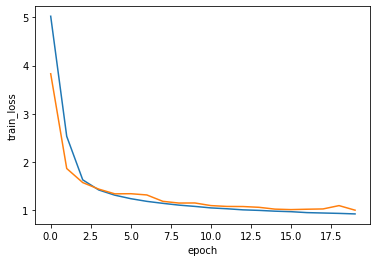

In [26]:
# plot training and validation loss to visualize the training progress.
# we should see that both the training and validation decrease steadily over time.
# once the validation loss stops decreasing, this is a signal that the model
# is starting to become overfit

# load metrics from logged csv file
version = model.logger.version
pt_metrics = pd.read_csv('./logs/linear/version_%i/metrics.csv'%version)
train = pt_metrics[~pt_metrics.train_loss.isna()]
val = pt_metrics[~pt_metrics.val_loss.isna()]

# plot metrics to seaborn lineplot
sns.lineplot(x=train.epoch,y=train.train_loss) #blue
sns.lineplot(x=val.epoch,y=val.val_loss) #orange
plt.show()

Test performance:
MSE = 0.943
R^2 = 0.817


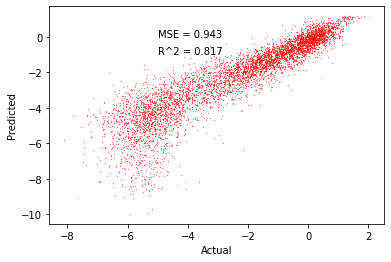

In [27]:
# Plot predicted v true scatterplot for test data

# define the training and test dataframes using the dm splits
train_data_frame = df.iloc[list(dm.train_idx)].copy()
test_data_frame = df.iloc[list(dm.test_idx)].copy()

# Set X as the true scores and Y as the predicted scores
X = test_data_frame['score'].tolist()
Y = []
for i in test_data_frame['AA_sequences']:
    Y.append(model.predict(i))

# Plot and annotate the test scatterplot
plt.scatter(X, Y, color='red', s = 0.05)
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.annotate(f"MSE = {metrics.mean_squared_error(X, Y):.3f}", (-5.0, 0.0))
plt.annotate(f"R^2 = {metrics.r2_score(X, Y):.3f}", (-5.0, -1.0))
print('Test performance:')
print(f"MSE = {metrics.mean_squared_error(X, Y):.3f}")
print(f"R^2 = {metrics.r2_score(X, Y):.3f}")

plt.show()

Training performance:
MSE = 0.888
R^2 = 0.820


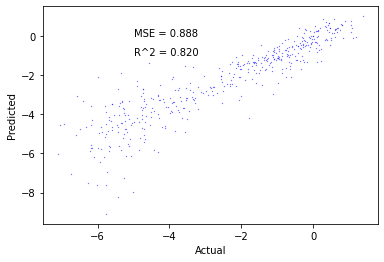

In [28]:
# Plot predicted v true scatterplot for training data

# Set X as the true scores and Y as the predicted scores
X2 = train_data_frame['score'].tolist()
Y2 = []
for i in train_data_frame['AA_sequences']:
    Y2.append(model.predict(i))

# plot only 1% of the data since there's so much
X2 = X2[:len(X2)//100]
Y2 = Y2[:len(Y2)//100]

# Plot and annotate the training scatterplot
plt.scatter(X2, Y2, color='blue', s = 0.05)
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.annotate(f"MSE = {metrics.mean_squared_error(X2, Y2):.3f}", (-5.0, 0.0))
plt.annotate(f"R^2 = {metrics.r2_score(X2, Y2):.3f}", (-5.0, -1.))
print('Training performance:')
print(f"MSE = {metrics.mean_squared_error(X2, Y2):.3f}")
print(f"R^2 = {metrics.r2_score(X2, Y2):.3f}")

plt.show()

# Note that the test statistics are most important, but if the model performs
# much better on the training data this can be another sign of overfitting